# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Открытие файла с данными и изучение общей информации. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

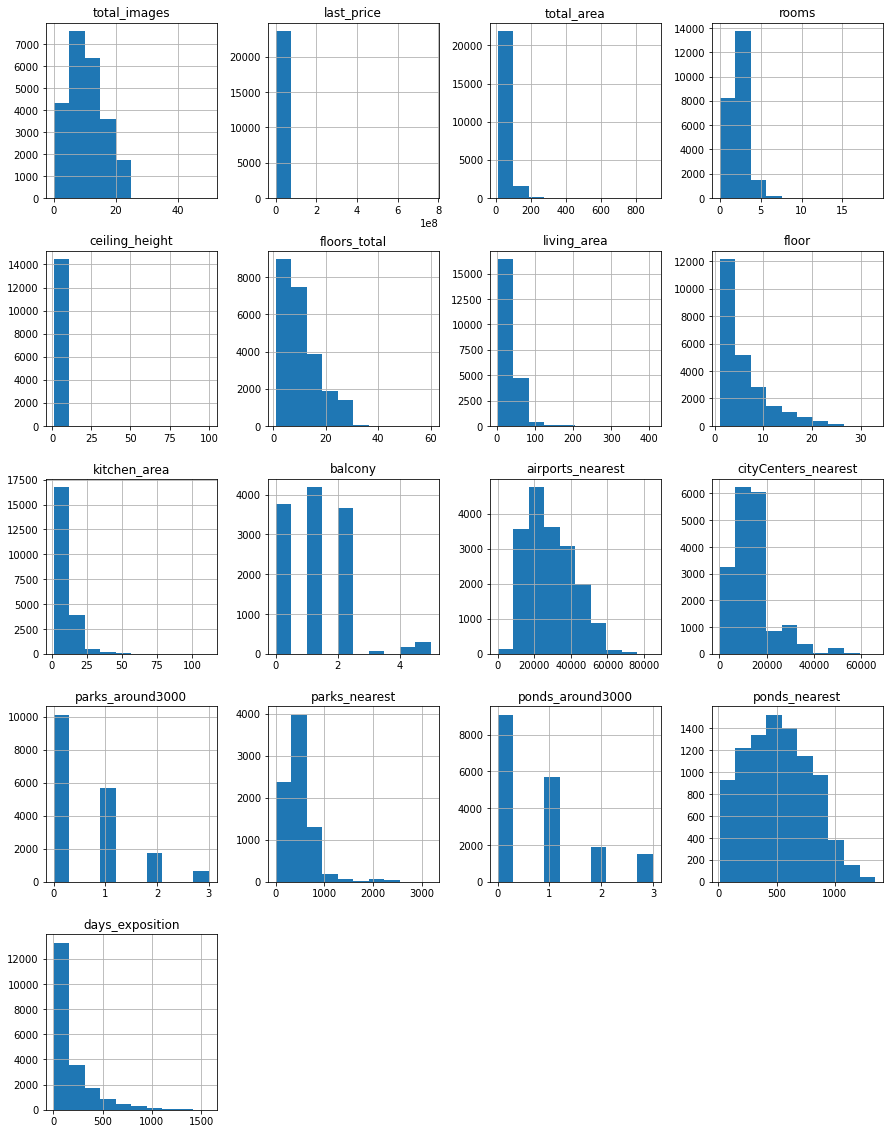

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
print(data.hist(figsize=(15, 20)))


### Предобработка данных

В колонке с балконами пропуски могут значить, что нет балкона
В колонке с метражом кухни пропуски могут значить, что квартира-студия и кухни как таковой нет
В колонке с парками в радиусе 3км пропуски могут означать, что парков в радиусе 3км нет
В колонке с прудами в радиусе 3км пропуски могут означать, что водоемов в радиусе 3км нет
В колонке с количеством дней от публикации до снятия объявления пропуски могут означать, что объявление еще не сняли
В колонке с жилой площадью пропуски могут означать, что помещение нежилое

In [2]:
fill_list=['balcony', 'kitchen_area', 'parks_around3000', 'ponds_around3000', 'living_area']
for i in fill_list:
    data[i]=data[i].fillna(0)
data['is_apartment']=data['is_apartment'].fillna(False)
print(data.isna())

       total_images  last_price  total_area  first_day_exposition  rooms  \
0             False       False       False                 False  False   
1             False       False       False                 False  False   
2             False       False       False                 False  False   
3             False       False       False                 False  False   
4             False       False       False                 False  False   
...             ...         ...         ...                   ...    ...   
23694         False       False       False                 False  False   
23695         False       False       False                 False  False   
23696         False       False       False                 False  False   
23697         False       False       False                 False  False   
23698         False       False       False                 False  False   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0        

День публикации изменен с типа данных object на datatime. Количество балконов изменено с float на int



In [3]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['balcony']=data['balcony'].astype('int')






    





In [4]:
#неявные дубликаты
duplicates=['посёлок', 'посёлок городского типа', 'поселок', 'посёлок городского типа', 'городской поселок', 'городской посёлок',
'коттеджный посёлок', 'коттеджный поселок']
name='посёлок'
for dulicate in duplicates:
    data['locality_name']=data['locality_name'].str.replace(dulicate, name)
data['locality_name'].unique()
    


array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

В высоте потолков высота потолком действительно была выше, чем может быть. Редкие значения были поделены на 10
Общая площадь квартиры также была прописана с ошибкой: значения, где площадь была больше 250, были поделены на 10
Площадь жилого помещения квартиры также была прописана с ошибкой: значения, где площадь была больше 250, были поделены на 10
Площадь кухонь также была прописана с ошибкой: значения, где площадь была больше 80, были поделены на 10    


In [6]:
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)
# а затем заполнить пропуски медианой
data['ceiling_height'].fillna(data['ceiling_height'].median())

0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23694    3.70
23695    2.65
23696    2.65
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

### Посчёт и добавлениев таблицу новых столбцов

In [7]:
data['price_one_metr']=data['last_price']/data['total_area']
data['price_one_metr']=data['price_one_metr'].round()
data['weekday']=data['first_day_exposition'].dt.weekday
data['month']=pd.DatetimeIndex(data['first_day_exposition']).month
data['year']=pd.DatetimeIndex(data['first_day_exposition']).year
def floor_type(row):
    if (row['floor']==row['floors_total']) & (row['floor']!=1):
        return 'последний'
    elif row['floor']==1:
        return 'первый'
    else:
        return 'другой'
data['floor_type']=data.apply(floor_type, axis=1)
data['cityCenters_nearest']=data['cityCenters_nearest']/1000
data['cityCenters_nearest']=data['cityCenters_nearest'].round()



### Проведение исследовательского анализа данных

Из данного графика можно сделать вывод, что бОлошую часть занимают жилые помещение(так как общая площадь составляет, в основном, до 200 кв.метров). Значения же больше-нежилые помещения(например, офисы)

[[<AxesSubplot:title={'center':'total_area'}>]]


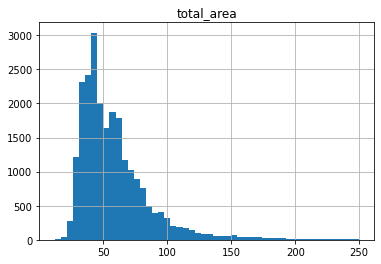

In [8]:
print(data.hist(['total_area'], bins=50))




Жилого помещения, логично, меньше, чем общей площади. Где на графике значение "0"-означает, что помещение нежилое

AxesSubplot(0.125,0.125;0.775x0.755)


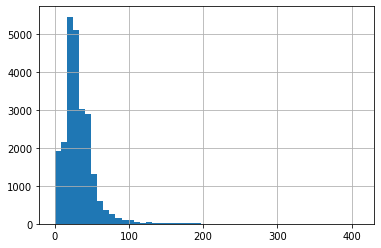

In [9]:
print(data['living_area'].hist(bins=50))

Площадь кухонь, в основном, до 20 квадратных метров. Где значения равны нулю-квартиры студии, где кухни как таковой нет

AxesSubplot(0.125,0.125;0.775x0.755)


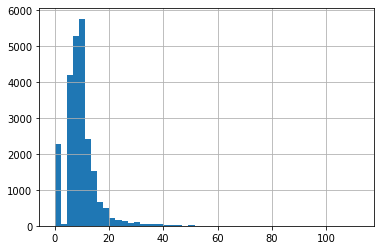

In [10]:
#data["last_price"].plot(kind="line")
print(data['kitchen_area'].hist(bins=50))

В основном, квартиры от 1 до 4 комнат. Значения, где 0 могут означать, что помещение нежилое и комнаты в этом случае 
не учитывались

AxesSubplot(0.125,0.125;0.775x0.755)


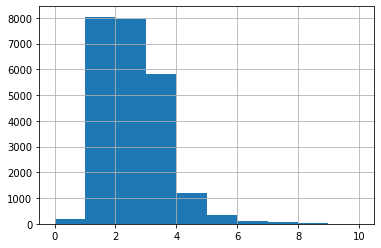

In [11]:
print(data['rooms'].hist(range=(0,10)))

В основном помещения с высотой потолков 2.5 метров

AxesSubplot(0.125,0.125;0.775x0.755)


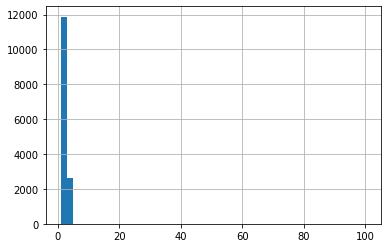

In [12]:
print(data['ceiling_height'].hist(bins=50))

В основном, помещения продаются на низких этажах. Логично даже предположить, что это старые дома-пятиэтажки

AxesSubplot(0.125,0.125;0.775x0.755)


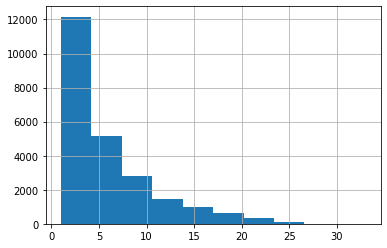

In [13]:
print(data['floor'].hist(bins=10))

Люди предпочитают покупать квартиры между первым и последним этажом. Также, последний этаж более предпочтителен, чем первый

AxesSubplot(0.125,0.125;0.775x0.755)


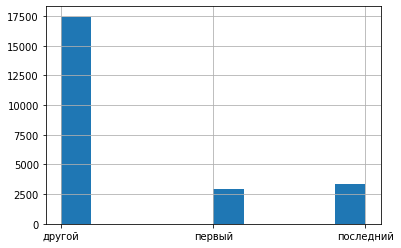

In [14]:
print(data['floor_type'].hist())

В основном продают помещения в старых-пятиэтажных домах

AxesSubplot(0.125,0.125;0.775x0.755)


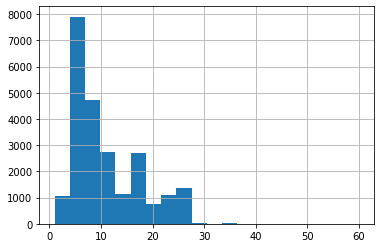

In [15]:
print(data['floors_total'].hist(bins=20))

В некоторых строках столбцов есть нули, так как это незаполненные пропуски, которые неизвестно как было заполнять. По тем данным,
что есть, можно сделать вывод, что в основном продают помещения близкие к центру города

AxesSubplot(0.125,0.125;0.775x0.755)


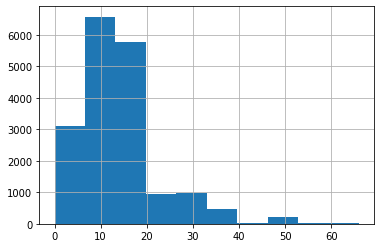

In [16]:
print(data['cityCenters_nearest'].hist())

В некоторых строках столбцов есть нули, так как это незаполненные пропуски, которые неизвестно как было заполнять. По тем данным,
что есть можно сделать вывод, что продают помещения в относительной близости к аэропорту(20км)

AxesSubplot(0.125,0.125;0.775x0.755)


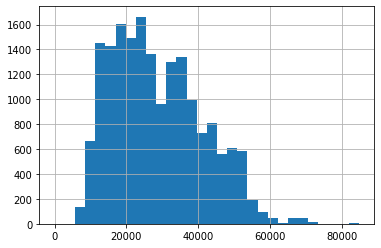

In [17]:
print(data['airports_nearest'].hist(bins=30))

В некоторых строках столбцов есть нули, так как это незаполненные пропуски, которые неизвестно как было заполнять. По тем данным,
что есть можно сделать вывод, что, в основном, продают помещения рядом с парками

AxesSubplot(0.125,0.125;0.775x0.755)


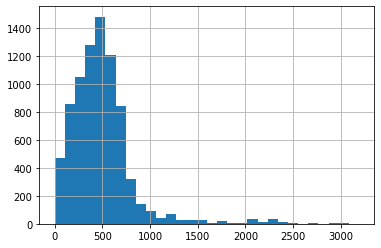

In [18]:
print(data['parks_nearest'].hist(bins=30))

Покупатели предпочитают покупать помещения во время рабочей недели. Больше в начале и конце, чем в середине

AxesSubplot(0.125,0.125;0.775x0.755)


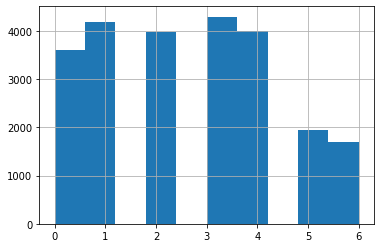

In [19]:
#data.info()
print(data['weekday'].hist(bins=10))


Чаще помещения покупают в холодное время года(первые 2 месяца и последние 2 месяца), чем в теплое(все остальные месяцы)

AxesSubplot(0.125,0.125;0.775x0.755)


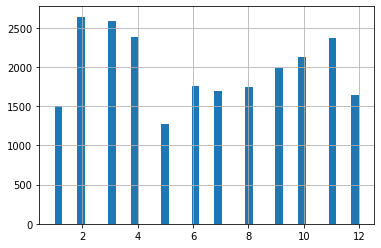

In [20]:
print(data['month'].hist(bins=40))

В среднем продажа занимает 158 дней. Учитывать медианное значение было бы неверно, так как во многих строках значение равно нулю,
что означает, что помещение всё еще продается.

AxesSubplot(0.125,0.125;0.775x0.755)
95.0
180.88863436982163
count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


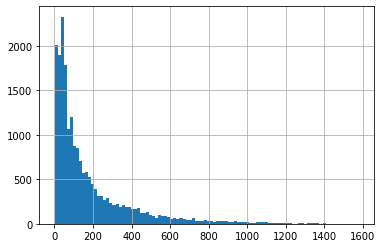

In [21]:
print(data['days_exposition'].hist(bins=100))
print(data['days_exposition'].median())
print(data['days_exposition'].mean())
print(data['days_exposition'].describe())


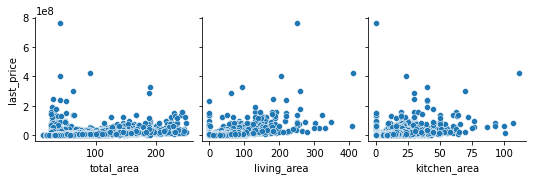

In [30]:
import seaborn as sns
sns.pairplot(data, x_vars=['total_area','living_area', 'kitchen_area'], y_vars='last_price', diag_kind="hist")

In [31]:
print(data['locality_name'].value_counts().head(11))

Санкт-Петербург      15721
посёлок Мурино         556
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Петергоф               201
Name: locality_name, dtype: int64


Самая высокая цена за квадратный метр в Санкт-Петербурге-128586.56 рублей.
Самая низкая цена за квадратный метр в посёлке Стрельна-91005.78 рублей.

In [32]:
top_10=data.pivot_table(index='locality_name', values=('price_one_metr'), aggfunc=('mean', 'count'))
top_10.columns=['price_one_metr', 'need_price_one_metr']
print(top_10.sort_values(by='need_price_one_metr', ascending=False).head(10))




                   price_one_metr  need_price_one_metr
locality_name                                         
Санкт-Петербург             15721        129333.668342
Зеленогорск                    24        115122.750000
Пушкин                        369        108111.303523
посёлок Репино                  4        104238.500000
Сестрорецк                    183        101757.639344
посёлок Лисий Нос               3        100661.000000
Кудрово                       173        100253.046243
деревня Мистолово              11         98550.000000
посёлок Левашово                1         96998.000000
Мурино                         34         92722.705882


Чем дальше объект от центра города, тем цена ниже. Однако, на промежутке от 25 до 30 киллометров некий "скачок". Возможно, 
там элитная загородная недвижимость

AxesSubplot(0.125,0.125;0.775x0.755)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_metr,weekday,month,year,floor_type
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.0,3,3,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82921.0,1,12,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92786.0,3,8,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,0.0,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.0,4,7,2015,другой
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.0,1,6,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,1.0,796.0,3.0,381.0,NaN,72491.0,1,3,2017,другой
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.0,4,False,...,0.0,NaN,0.0,NaN,45.0,52542.0,0,1,2018,другой
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,False,...,0.0,NaN,0.0,NaN,NaN,44092.0,6,2,2018,первый
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,0.0,12,False,...,2.0,173.0,3.0,196.0,602.0,149511.0,1,3,2017,другой


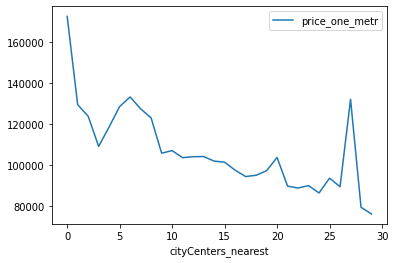

In [36]:
print(data.query('locality_name=="Санкт-Петербург"').pivot_table(index='cityCenters_nearest', values='price_one_metr', \
aggfunc='median').plot())
data

### Общий вывод

Выводы оказались достаточно очевидными: в городе цена за квадратный метр выше, чем в области; квартиры на последних этажах \
дороже, чем на первых; люди предпочитают покупать квартиры между первым и последним этажом нежели на первом или посоледним в \
сумме. Однако, можно сделать и нужные бизнесу выводы. Например, люди чаще покупают квартиры в первые 2 и последние 2 месяца в \
году; чаще продают квартиры в пятиэтажных домах, чем в многоэтажных; квартиры покупают в рабочие дни чаще, чем в выходные. 